In [19]:
import sys
import os

# Add the parent directory (one level up) to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

from modules import model, dataset_design, feature_extractor

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import joblib
import os

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("always")


In [3]:
#load data and design train test sets using module
dd = dataset_design.Dataset_designer()
raw_data = dd.extract('../data_sources/raw_data_v1.0.parquet')
data = dd.sample(raw_data)
desc = dd.describe()
print(desc)
dd.load(data, desc['Train default storage'], desc['Test default storage'])

{'version': 'v1.0', 'Train default storage': '../data_sources/train_data_v1.0.parquet', 'Test default storage': '../data_sources/test_data_v1.0.parquet', 'description': {'No. Train Samples': 1186297, 'Train set fraud/no fraud split': '5196 / 1181101', 'No. Test Samples': 296575, 'fraud/no fraud split': '1300 / 295275'}}
Train data saved to ../data_sources/train_data_v1.0.parquet
Test data saved to ../data_sources/test_data_v1.0.parquet


In [4]:
#use feature extractor to extract features
fe = feature_extractor.Feature_Extractor()
data_train_test, _ = fe.transform(data[0], data[1])

/home/kaneel123/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '20/06/1986' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/kaneel123/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '23/04/1941' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/kaneel123/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '16/12/1980' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/kaneel123/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '26/10/1988' in DD/MM/YYYY 

Columns with high correlations:


In [5]:
#extract data from
X_train, y_train, X_test, y_test = data_train_test

In [6]:
#print out data information
print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")

#column names
print(f"Feature Names: {X_train.columns}")

X train shape: (1067635, 17)
y train shape: (1067635,)
X test shape: (216213, 17)
y test shape: (216213,)
Feature Names: Index(['day_of_trans', 'hour_of_trans', 'month_of_trans', 'age', 'state',
       'merchant', 'category', 'sex', 'city', 'zip', 'job', 'amt', 'lat',
       'long', 'city_pop', 'merch_lat', 'merch_long'],
      dtype='object')


# Preprocessing steps #

1. Scale numerical columns using sklearn standard scaler.

2. Use SMOTE for oversampling the minority class.  


In [7]:
# Define categorical and numerical columns
categorical_cols = ['state', 'merchant', 'category', 'sex', 'city', 'zip', 'job']
numerical_cols = ['day_of_trans', 'hour_of_trans', 'month_of_trans', 'age', 'amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']

#preprocessor that scales the numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ])

#smote method for oversampling fraud transaction class
smote = SMOTE(random_state = 42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Models #

1. Logistic Regression with balanced class weight.
2. Random Forest
3. Support Vector Machines 

In [8]:
# Define models
logistic_regression = LogisticRegression(class_weight='balanced', random_state=42)
# logistic_regression = LogisticRegression(
#     penalty='l1', 
#     solver='liblinear',  # 'liblinear' or 'saga' solvers support L1 regularization
#     class_weight='balanced', 
#     random_state=42
# )
random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)
svc = SVC(class_weight='balanced', random_state=42) 


# Create pipelines for each model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', logistic_regression)
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', random_forest)
])

svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', svc)
])

# Train and fit models #

### Logistic Regression ###

Model: Logistic Regression
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    215271
         1.0       0.06      0.74      0.11       942

    accuracy                           0.95    216213
   macro avg       0.53      0.84      0.54    216213
weighted avg       0.99      0.95      0.97    216213

[[204252  11019]
 [   244    698]]


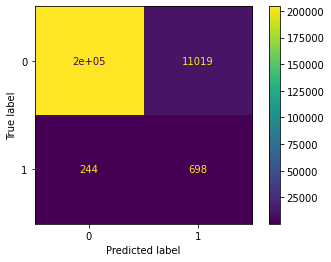

In [9]:
# Train the model
lr_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = lr_pipeline.predict(X_test)
    
# Evaluation metrics
print(f"Model: Logistic Regression")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()


In [38]:
#save model
model_name = 'logistic_regression'  # Example model name
model_version = 'v1'
model_path = f'../storage/models/artifacts/{model_name}_{model_version}.pkl'
joblib.dump(lr_pipeline, model_path)

['../storage/models/artifacts/logistic_regression_v1.pkl']

In [39]:
#save history of the model
# Predict on test set
y_pred = lr_pipeline.predict(X_test)
report = classification_report(y_test, y_pred, output_dict = True)
ac = accuracy_score(y_test, y_pred)

# Example of an existing DataFrame (you can replace this with your actual DataFrame)
model_history_df = pd.DataFrame(columns=['Model', 'Version', 'Precision', 'Recall', "Accuracy"])
model_data = {
    'Model': model_name,
    'Version': model_version,
    'Precision': report['1.0']['precision'],
    'Recall': report['1.0']['recall'],
    'Accuracy': ac
}

#append data to history data frame
logistic_df = pd.DataFrame(model_data, index = [0])
model_history_df = pd.concat([model_history_df, logistic_df], ignore_index = True)

#save dataframe
model_history_df.to_csv("../storage/models/model_history.csv", index = False)

### Random Forest ###

Model: Random Forests
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    215271
         1.0       0.37      0.72      0.49       942

    accuracy                           0.99    216213
   macro avg       0.68      0.86      0.74    216213
weighted avg       1.00      0.99      0.99    216213

[[214124   1147]
 [   267    675]]


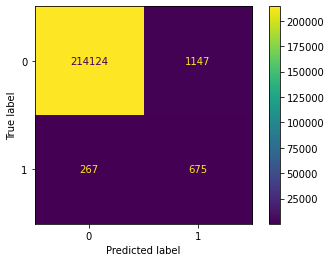

In [29]:
# Train the model
rf_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = rf_pipeline.predict(X_test)
    
# Evaluation metrics
print(f"Model: Random Forests")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()

In [40]:
#save model
model_name = 'random forest'  # Example model name
model_version = 'v1'
model_path = f'../storage/models/artifacts/{model_name}_{model_version}.pkl'
joblib.dump(rf_pipeline, model_path)

['../storage/models/artifacts/random forest_v1.pkl']

In [41]:
#save history of the model
# Predict on test set
y_pred = rf_pipeline.predict(X_test)
report = classification_report(y_test, y_pred, output_dict = True)
ac = accuracy_score(y_test, y_pred)

# Example of an existing DataFrame (you can replace this with your actual DataFrame)
model_data = {
    'Model': model_name,
    'Version': model_version,
    'Precision': report['1.0']['precision'],
    'Recall': report['1.0']['recall'],
    'Accuracy': ac
}

#append data to history data frame
random_forest_df = pd.DataFrame(model_data, index = [0])
model_history_df = pd.concat([model_history_df, random_forest_df], ignore_index = True)

#save dataframe
model_history_df.to_csv("../storage/models/model_history.csv", index = False)

### Support Vector Classifier ###

In [38]:
# Train the model
svc_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = svc_pipeline.predict(X_test)
    
# Evaluation metrics
print(f"Model: Support Vector Machines")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
